In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import rasterio
import math
from shapely.geometry import Point
import geopandas as gpd
import cv2

In [2]:

import os
from osgeo import gdal
import rasterio
import geopandas as gpd
import rasterio.mask
from rasterio.windows import Window
import sys
from shapely.geometry import mapping
sys.path.append(r'E:/gitlab/geoloc2/Detecciondeterrenos')
from codigos import Generar_txt
###path de yolo dentro de computadora
os.chdir(r'C:/Users/ASUS/Inteligencia_Artificial/yolov7')
from detect_Alberto_v4 import *
from scipy.ndimage import rotate as rotate_image
from shapely import geometry
import time
import datetime

In [3]:
Modelo=modelo(weights=r"C:\Users\ASUS\Inteligencia_Artificial\yolov7\runs\train\Alberto_a22\weights\best_Alberto_a22.pt")

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 



In [4]:
raster=r"C:\Users\ASUS\Desktop\atlacoa2.tif"

In [5]:
src=rasterio.open(raster)
f=src.get_transform()
sa=gpd.GeoSeries(Point(f[0],f[3]),crs="3857")
saa=sa.to_crs("6364")
angulo=float(str(saa[0]).split()[-1].replace(")",""))
metrosxpixel=f[1]
crs=src.meta.get("crs")

img=cv2.imread(raster)
edges = cv2.bitwise_not(cv.Canny(img[:,:,0],100,255))/255
cv2_imshow("s",np.array(np.stack([edges,edges,edges],axis=-1)*img,dtype="uint8"))
rgb_edges=np.stack([edges,edges,edges],axis=-1)
rse=np.array(rgb_edges*img,dtype="uint8")

In [6]:
# w=img.shape[0]
# h=img.shape[1]
# vector=Modelo.detect(opt_conf_thres=.5,opt_source=raster)
# # proyecciones=shapes[0].get('coordinates')[0][:-1]
# # Vector de deteccion de yolov
# df_cache=vector2xy(vector,w,h)
# imshow_detect(df_cache=df_cache,imagen_n=img)

In [7]:
gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
a0=np.array(cv2.threshold(normalizar_array(10**(np.array(gray,dtype="float64")/255)),.2,1,0)[1]*255,dtype="uint8")
contours,his=cv2.findContours(a0,0,1)
a1=np.zeros_like(a0)

for c in contours:
    area = cv2.contourArea(c)
    if area > 40 and area < 100000:
        cv2.drawContours(a1, [c], 0, (255, 255, 255), -1)
cv2_imshow("s",a1)
len(contours)

907

In [8]:
X = img.reshape((-1,3))
f=1
axis_n1=range(3)
X=np.array(X/f,dtype="uint8")*f
Z = np.float32(X)
kmeans=pd.DataFrame(Z,columns=axis_n1)
kmeans["grupo"]=0
centros=np.array([[40,40,40],[132,117,126],[57,72,74],[124,152,178],[106,106,166],[16,15,205],[189, 194, 197]])#[parametro1,parametro2,parametro3]
kmeans["menor"]=1e15
for i,pt in enumerate(centros):
    kmeans["d"+str(i)]=list(np.sqrt(np.sum((centros[i]-Z)**2,axis=1)))
    kmeans.loc[kmeans["d"+str(i)]<=kmeans["menor"],"grupo"]=i
    kmeans.loc[kmeans["d"+str(i)]<=kmeans["menor"],"menor"]=kmeans["d"+str(i)][kmeans["d"+str(i)]<=kmeans["menor"]]
res=centros[kmeans["grupo"].values]
res2 = np.array(res.reshape((img.shape[0],img.shape[1],3)),dtype="uint8")
cv2.namedWindow("result", cv2.WINDOW_NORMAL)
cv2_imshow("result",res2)

In [9]:
img=rse.copy()
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
hsv_low=np.array([ 0,  0, 73], dtype="uint8")
hsv_high= np.array([179, 255, 255], dtype="uint8")
mask = cv2.inRange(hsv, hsv_low, hsv_high)

In [10]:
_,ix=cv2.threshold(mask,70,255,1)
ix=ix/255
black=np.full((ix.shape[0],ix.shape[1]),0)
for x in range(ix.shape[1]):
    s=ix[:,x]
    for pases in range(10):
        for i in range(len(s)-1):
            if s[i]==0 and s[i-1]==1 and s[i+1]==1:
                s[i]=1
    contador=0
    altura=0
    alt=[]
    for i in range(len(s)):
        if s[i]!=0 and s[i]!=1:
            print(s[i])
        if i==0 and s[0]==0:
            contador=0
            altura=0
        elif i==0 and s[0]==1:
            contador=1
            altura=0
        else:
            if s[i]==s[i-1]:
                if s[i-1]<1:
                    contador=contador
                    altura=altura
                else:
                    contador+=1
                    altura=altura
            else:
                if s[i-1]<1:
                    contador=1
                    altura=0
                else:
                    contador=contador
                    if contador<np.round(5/metrosxpixel,0):
#                         print(str(x)+" "+str(i))
                        altura=altura+(contador)*math.cos(angulo*math.pi/180)*metrosxpixel
#                     elif contador>10:
#                         altura=altura
                    else:
                        altura=(contador)*math.cos(angulo*math.pi/180)*metrosxpixel
        alt.append(altura)
#         black[x,i]=altura
    black[:,x]=alt
plt.imshow(black)

In [11]:
plt.imshow(cv2.cvtColor(res2,cv2.COLOR_BGR2RGB))

In [12]:
for centro in centros:
    print(centro)
    cv2_imshow("a",np.array(np.full((10,10,3),tuple(centro)),dtype="uint8"))

[40 40 40]
[132 117 126]
[57 72 74]
[124 152 178]
[106 106 166]
[ 16  15 205]
[189 194 197]


In [13]:
white=np.full((img.shape[0],img.shape[1]),0)
# white1=np.full((img.shape[0],img.shape[1]),0)
white[[res2==[57,72,74]][0][:,:,0]]=255
white[[res2==[106,106,166]][0][:,:,0]]=255
white[[res2==[189, 194, 197]][0][:,:,0]]=255
white[[res2==[16,15,205]][0][:,:,0]]=255
cv2_imshow("s",np.array(white,dtype="uint8"))
# blanco=np.array(np.where(res2[:,:,0]==[189]))
# blanco_x=blanco[0,:]
# blanco_y=blanco[1,:]
# rojo=np.array(np.where(res2[:,:,0]>=166))
# rojo_x=rojo[0,:]
# rojo_y=rojo[1,:]
# white[blanco_x,blanco_y]=255
# white[rojo_x,rojo_y]=255
# cv2_imshow("s",np.array(white,dtype="uint8"))


In [14]:
# [x for x in if x[0:]==0]

In [15]:
white.shape

(301, 532)

In [16]:
f=np.array(np.where([res2[:,:,2]>=166 , res2[:,:,0]!=188])) 
y1=[i for i,y in enumerate(f[0,:]) if y==1]
f=f[1:,y1]
f=np.moveaxis(f,0,-1)
# white[]
# white[[(x[0],x[0]) for x in f]]=255
cv2_imshow("s",np.array(white,dtype="uint8"))

In [17]:
# # Importing the libraries
# import cv2
# import numpy as np

# # Reading the image and converting the image to B/W
# image = cv2.imread(r"C:\Users\ASUS\Inteligencia_Artificial\pines\0_0_2deteccion.png")
# gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# gray_image = np.float32(gray_image)

# # Applying the function
# dst = cv2.cornerHarris(gray_image, blockSize=2, ksize=3, k=0.04)

# # dilate to mark the corners
# dst = cv2.dilate(dst, None)
# image[dst > 0.01 * dst.max()] = [0, 255, 0]

# cv2_imshow('haris_corner', image)
# # cv2.waitKey()
# # cv2.destroyAllWindows()


In [18]:
# import numpy as np 
# import cv2 
# from matplotlib import pyplot as plt

# # Read the training and query images
# query_img = cv2.imread(r"C:\Users\ASUS\Desktop\2.png") 
# train_img = cv2.imread(r"C:\Users\ASUS\Desktop\1.png") 
 
# # Convert the images to grayscale 
# query_img_gray = cv2.cvtColor(query_img,cv2.COLOR_BGR2GRAY) 
# train_img_gray = cv2.cvtColor(train_img, cv2.COLOR_BGR2GRAY) 
 
# # Initialize the ORB detector algorithm 
# orb = cv2.ORB_create() 
 
# # Detect keypoints (features) cand calculate the descriptors
# query_keypoints, query_descriptors = orb.detectAndCompute(query_img_gray,None) 
# train_keypoints, train_descriptors = orb.detectAndCompute(train_img_gray,None) 
 
# # Match the keypoints
# matcher = cv2.BFMatcher() 
# matches = matcher.match(query_descriptors,train_descriptors) 
 
# # Draw the keypoint matches on the output images
# output_img = cv2.drawMatches(query_img, query_keypoints, 
# train_img, train_keypoints, matches,None) 
 
# # output_img = cv2.resize(output_img, (1200,650)) 
 
# # Save the final image 
# cv2.imshow("feature_matching_result.jpg", output_img) 
 
# # Close OpenCV upon keypress
# cv2.waitKey()
# cv2.destroyAllWindows()

In [19]:
# import numpy as np
# import cv2
# img=cv2.imread(r"C:\Users\ASUS\Desktop\1.png") 
# pts = np.array([[542, 107], [562, 102], [582, 110], [598, 142], [600, 192], [601, 225], [592, 261], [572, 263], [551, 245], [526, 220], [520, 188], [518, 152], [525, 127], [524, 107]], dtype=np.int32)

# mask = np.zeros((img.shape[0], img.shape[1]))

# cv2.fillConvexPoly(mask, pts, 1)
# mask = mask > 0 # To convert to Boolean

# out = np.zeros_like(img)
# out[mask] = img[mask]
# cv2.imshow('Extracted Image', out)
# cv2.waitKey()
# cv2.destroyAllWindows()

In [20]:
# import cv2
# import numpy as np

# # Read the image
# image = cv2.imread(raster)

# # Convert the image to NumPy array
# res2 = np.array(image)

# # Extract the pixels that are red
# np.where(res2[:,:,2].all()>=166 & res2[:,:,0].all()!=186)

# # # Check if any of the pixels are red
# # if np.any(red_pixels):
# #   # Mask the image to only show the red pixels
# #   masked_image = res2[red_pixels]

# #   # Display the masked image
# #   cv2.imshow("Masked Image", masked_image)
# #   cv2.waitKey(0)

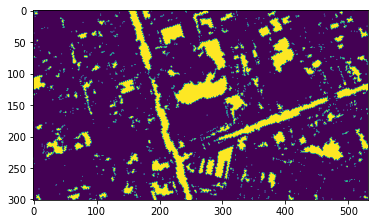

In [26]:
%matplotlib inline
white=white*rgb_edges[:,:,0]
contours,hist=cv2.findContours(np.array(white,dtype="uint8"),0, cv2.CHAIN_APPROX_SIMPLE)

cv2.drawContours(white,contours,-1,(700),-1)
area=[cv2.contourArea(x) for x in contours] 
for cnt in contours:
    x,y=cnt.mean(axis=0,dtype="int")[0]
    cv2.fillPoly(white, cnt, int(black[y,x]))
plt.imshow(white)

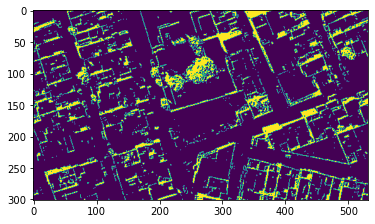

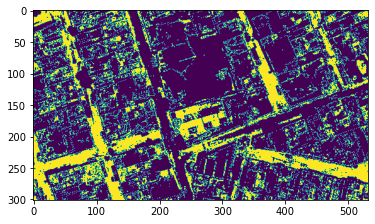

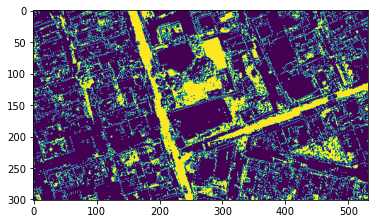

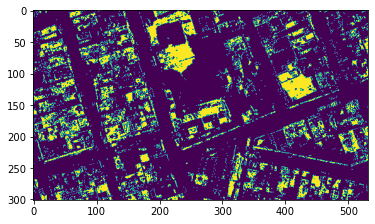

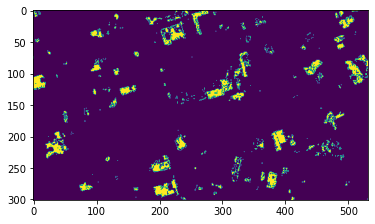

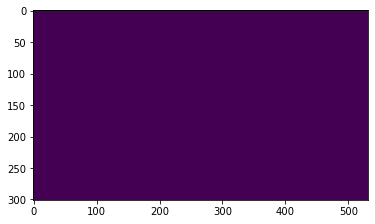

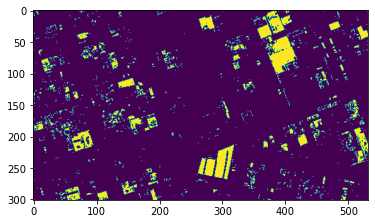

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
for i in range(len(centros)):
    a=np.zeros_like(img[:,:,0])
    a[[res2==centros[i]][0][:,:,0]]=255
    plt.imshow(a)
    plt.show()

In [22]:
array=black.copy()
mean = np.mean(black[black>0])
array[array > mean]= mean
plt.imshow(array)

In [23]:
from affine import Affine
##extremo superior izquierdo
# latitud=-11094158.14
# longitud=2188764.88
# metrosxpixel=10
# f=2
crs=3857
matriz=array*rgb_edges[:,:,0]*white/255.
# matriz=np.array(np.abs(mask-1),dtype="uint8")*105

h,w=matriz.shape
# matriz=cv2.resize(np.array(black,dtype="uint8"),(int(w/2),int(h/2)))
# matriz=cv2.resize(np.array(black,dtype="uint8"),(int(w*f),int(h*f)),cv2.INTER_NEAREST)
transform=src.meta.get("transform")
# transform=Affine(metrosxpixel,0,latitud,0,-metrosxpixel,longitud) ## 0 representa las componetes de direccion de la coordenada
out_meta=({"driver": "GTiff",
            "height": matriz.shape[0],
            "width": matriz.shape[1],
            "count":1,
            "dtype":np.float32,
            "crs":crs,
          'transform':transform})
with rasterio.open(r"E:\geoshapes\black_nuevo1.tif",'w', **out_meta) as dest_file:
    dest_file.write(matriz, 1)

In [24]:
matriz

array([[          0,           0,           0, ...,           0,           0,           0],
       [          0,           0,           0, ...,           0,           0,           0],
       [          0,           0,           0, ...,           0,           0,           0],
       ...,
       [          0,           0,           0, ...,   0.0039216,   0.0039216,      2.7451],
       [          0,           0,           0, ...,           0,           0,   0.0039216],
       [          0,           0,           0, ...,           0,           0,           0]])